In [5]:
import math
import numpy as np
from numpy.linalg import eigh

L = 1000
rho = 30
kappa = 0.1
disorder = 5


# Constructing H


H = np.diag(np.full(L, disorder)) + np.diag(np.ones(L - 1), k=1) + np.diag(np.ones(L - 1), k=-1)
H[L-1,0] = 1
H[0,L-1] = 1
print(H)


#Constructing X

row_vector = np.linspace(-rho,rho,L)
X = np.zeros((L,L))
X[:] = row_vector
#print(X)

localizer = np.bmat([[-H,kappa * X], [kappa * X, H]])
#print(localizer)


eigvals, eigenvectors = eigh(localizer)

#show histogram of eigenvalues
import matplotlib.pyplot as plt
plt.hist(eigvals, bins=100, range=(-10, 10), density=True)
plt.title('Eigenvalue Distribution')

#take smallest 100 positive eigenvalues



[[5. 1. 0. ... 0. 0. 1.]
 [1. 5. 1. ... 0. 0. 0.]
 [0. 1. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 5. 1. 0.]
 [0. 0. 0. ... 1. 5. 1.]
 [1. 0. 0. ... 0. 1. 5.]]


KeyboardInterrupt: 

[3.         3.00003948 3.00003948 3.00015791 3.00015791 3.0003553
 3.0003553  3.00063162 3.00063162 3.00098688 3.00098688 3.00142105
 3.00142105 3.00193413 3.00193413 3.00252609 3.00252609 3.0031969
 3.0031969  3.00394654 3.00394654 3.00477499 3.00477499 3.0056822
 3.0056822  3.00666814 3.00666814 3.00773278 3.00773278 3.00887607
 3.00887607 3.01009797 3.01009797 3.01139842 3.01139842 3.01277738
 3.01277738 3.01423479 3.01423479 3.0157706  3.0157706  3.01738474
 3.01738474 3.01907715 3.01907715 3.02084776 3.02084776 3.02269651
 3.02269651 3.02462332 3.02462332 3.02662811 3.02662811 3.02871081
 3.02871081 3.03087133 3.03087133 3.03310959 3.03310959 3.0354255
 3.0354255  3.03781897 3.03781897 3.0402899  3.0402899  3.04283819
 3.04283819 3.04546375 3.04546375 3.04816648 3.04816648 3.05094625
 3.05094625 3.05380298 3.05380298 3.05673653 3.05673653 3.05974681
 3.05974681 3.06283368 3.06283368 3.06599702 3.06599702 3.06923672
 3.06923672 3.07255264 3.07255264 3.07594466 3.07594466 3.07941263

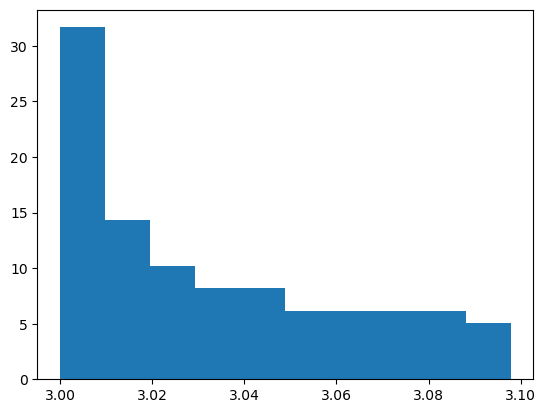

In [ ]:
positive_eigvals = eigvals[eigvals > 0]
smallest_100_positive_eigvals = positive_eigvals[:100]

print(smallest_100_positive_eigvals)
plt.hist(smallest_100_positive_eigvals,density=True)
plt.show()

In [ ]:
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

def create_localiser(L,rho,kappa,disorder):
    # Function to create the localiser matrix of a 1D Anderson model
    # Note the open boundary conditions
    # This also includes the creation of the position operator X

    # on diagonal disorder
    diag = (np.random.rand(L)-0.5) * disorder
    # off diagonal hopping terms
    off_diag = np.ones(L-1)

    H = sp.diags([off_diag,diag,off_diag],[-1,0,1],shape=(L,L),format='lil')

    #H[L-1,0] = 1
    #H[0,L-1] = 1

    row_vector = np.linspace(-rho,rho,L)
    X = sp.diags(row_vector,0,shape=(L,L),format='csr')

    localiser = sp.bmat([[-H,kappa * X],[kappa * X,H]],format='csr')

    return localiser


def find_eigenvalues(localiser, num_eigenvalues=800):
    # Function to find the positive eigenvalues of the localiser matrix
    # numpy eigsh is best for the sparse case.
    eigvals, eigvecs = eigsh(localiser, k=num_eigenvalues,sigma = 0, which='LM')
    positive_eigvals = eigvals[eigvals > 0]
    return positive_eigvals


def calculate_r(eigvals):
    # Once eigenvalues are found, calculate the r value
    eigvals_s = np.diff(eigvals)
    min_eigvals_s = np.array([min(eigvals_s[i],eigvals_s[i+1]) for i in range(len(eigvals_s)-1)])
    max_eigvals_s = np.array([max(eigvals_s[i],eigvals_s[i+1]) for i in range(len(eigvals_s)-1)])
    r = min_eigvals_s / max_eigvals_s
    return r.sum() / len(r)

    


def single_iteration(args):
    L, rho, kappa, disorder, i = args
    localiser = create_localiser(L,rho,kappa,disorder)
    positive_eigvals = find_eigenvalues(localiser, L//5)
    r = calculate_r(positive_eigvals)
    print(f"   r value for {i+1}th iteration: {r}")
    return r

L_values = [500,1000,2000,4000,8000]
rho = 30
kappa = 0.1
disorder_values = np.linspace(0,5,11)
num_iter = 10



print("Calculating r values for different disorder strengths and system sizes")
print("First L/5 eigenvalues are used to calculate r")
results = [[] for _ in L_values]
if __name__ == '__main__':
    with Pool() as pool:
        for L in L_values:
            print(f"System size L: {L}")
            for disorder in disorder_values:

                args_list = [(L,rho,kappa,disorder,i) for i in range(num_iter)]

                r_values_for_disorder = pool.map(single_iteration,args_list)



# for L in L_values:
#     print(f"System size L: {L}")
#     for disorder in disorder_values:
#         print(f"Calculating for disorder strength: {disorder}")
#         r_values_for_disorder = []
#         for i in range(num_iter):
#             print(f"  Iteration {i+1}/10")
#             localiser = create_localiser(L,rho,kappa,disorder)
#             positive_eigvals = find_eigenvalues(localiser, L/5)
#             r = calculate_r(positive_eigvals)
#             print(f"   r value for {i+1}th iteration: {r}")
#             r_values_for_disorder.append(r)
#         print(f"Disorder: {disorder}, r: {np.mean(r_values_for_disorder)}")




Calculating r values for different disorder strengths...
Calculating for disorder strength: 0.0
  Iteration 1/10
   r value for 1th iteration: 7.639210577936091e-13
  Iteration 2/10
   r value for 2th iteration: 5.264648908207858e-13
  Iteration 3/10
   r value for 3th iteration: 7.543134001701403e-13
  Iteration 4/10
   r value for 4th iteration: 5.313459263806097e-13
  Iteration 5/10
   r value for 5th iteration: 7.507878858136482e-13
  Iteration 6/10
   r value for 6th iteration: 6.383519545069551e-13
  Iteration 7/10
   r value for 7th iteration: 7.069008595561222e-13
  Iteration 8/10
   r value for 8th iteration: 7.561233060052063e-13
  Iteration 9/10
   r value for 9th iteration: 4.774654894764168e-13
  Iteration 10/10
   r value for 10th iteration: 5.898136485641143e-13
Disorder: 0.0, r: 6.495488419087608e-13
Calculating for disorder strength: 0.5
  Iteration 1/10
   r value for 1th iteration: 0.5036648731325207
  Iteration 2/10
   r value for 2th iteration: 0.5042058469709018
 

In [ ]:
print(localiser)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 24000 stored elements and shape (6000, 6000)>
  Coords	Values
  (0, 0)	-5.0
  (0, 1)	-1.0
  (0, 2999)	-1.0
  (0, 3000)	-3.0
  (1, 0)	-1.0
  (1, 1)	-5.0
  (1, 2)	-1.0
  (1, 3001)	-2.9979993331110375
  (2, 1)	-1.0
  (2, 2)	-5.0
  (2, 3)	-1.0
  (2, 3002)	-2.995998666222074
  (3, 2)	-1.0
  (3, 3)	-5.0
  (3, 4)	-1.0
  (3, 3003)	-2.993997999333111
  (4, 3)	-1.0
  (4, 4)	-5.0
  (4, 5)	-1.0
  (4, 3004)	-2.9919973324441482
  (5, 4)	-1.0
  (5, 5)	-5.0
  (5, 6)	-1.0
  (5, 3005)	-2.9899966655551853
  (6, 5)	-1.0
  :	:
  (5993, 5994)	1.0
  (5994, 2994)	2.9899966655551844
  (5994, 5993)	1.0
  (5994, 5994)	5.0
  (5994, 5995)	1.0
  (5995, 2995)	2.9919973324441482
  (5995, 5994)	1.0
  (5995, 5995)	5.0
  (5995, 5996)	1.0
  (5996, 2996)	2.9939979993331107
  (5996, 5995)	1.0
  (5996, 5996)	5.0
  (5996, 5997)	1.0
  (5997, 2997)	2.9959986662220737
  (5997, 5996)	1.0
  (5997, 5997)	5.0
  (5997, 5998)	1.0
  (5998, 2998)	2.9979993331110366
  (5998, 

In [7]:
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import math
from SLmodels import OneDimensionalAnderson

models = [OneDimensionalAnderson(L=500,rho=30,kappa=0.1,disorder=d) for d in np.linspace(0.2,5,4)]

eigvalsH = [models[i].find_eigenvalues(models[i].H)[0] for i in range(len(models))]
#eigvecsSL = [models[i].find_eigenvalues(models[i].SL)[0] for i in range(len(models))]
#eigvecsH, eigvalsH = model.find_eigenvalues(model.H)
#eigvecs, eigvals = model.find_eigenvalues(model.SL)
# plot histogram of eigenvalues



# r, z = model.compute_statistics(model.SL)
# print(f"r: {r}, z: {z}")

# def single_iteration(args):
#     L, rho, kappa, disorder, i = args
#     model = OneDimensionalAnderson(L=L, rho=rho, kappa=kappa, disorder=disorder)
#     eigvecs, eigvals = model.find_eigenvalues(model.SL)

#     r, z = model.compute_statistics(model.SL)
#     print(f"   r value for {i+1}th iteration: {r}")
#     return r

[np.float64(0.7876832253179917), np.float64(0.36200834495884965), np.float64(0.4120614357797457), np.float64(0.432751968394054)]
[-0.61052245 -0.5980062  -0.58647287 -0.5750955  -0.56166852 -0.55357568
 -0.53967063 -0.52737691 -0.51425129 -0.5007404  -0.49074918 -0.47397422
 -0.46644261 -0.4527308  -0.4402759  -0.42672935 -0.41115364 -0.40229935
 -0.39190369 -0.37700438 -0.36502319 -0.3548762  -0.34205645 -0.33023302
 -0.31712495 -0.30509569 -0.29102075 -0.27660332 -0.26965568 -0.25575519
 -0.24496264 -0.22974149 -0.21812274 -0.20743651 -0.18908021 -0.18353713
 -0.16772662 -0.15344353 -0.14481259 -0.13056894 -0.11752826 -0.10831934
 -0.09132265 -0.07891491 -0.06791749 -0.05750259 -0.04427517 -0.02978038
 -0.01781744 -0.00184175  0.00921018  0.0197346   0.03388722  0.04455855
  0.05592723  0.07060155  0.08289446  0.09472509  0.10390371  0.1184425
  0.13221798  0.14489383  0.15659653  0.16881787  0.18147064  0.19959967
  0.20732327  0.22246402  0.23194327  0.24316687  0.25650692  0.26910

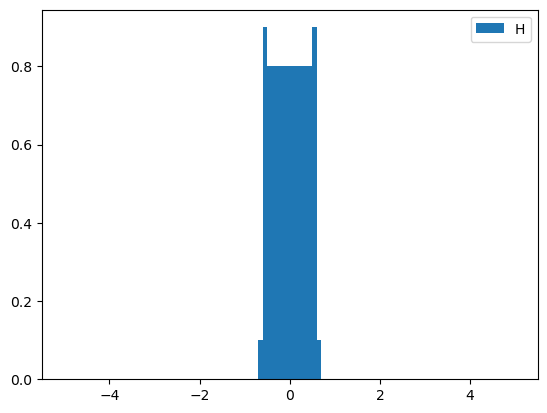

In [10]:

rvalsH = [models[i].calculate_r(eigvalsH[i]) for i in range(len(models))]
print(rvalsH)
print(eigvalsH[0])
eigvalsH = [eigvalsH[i].flatten() for i in range(len(models))]
#eigvalsSL = [eigvecsSL[i].flatten() for i in [3]]

plt.hist(eigvalsH[0], bins=100, range=(-5, 5), density=True)
#plt.hist(eigvalsSL, bins=100, range=(-5, 5), alpha=0.5, density=True)
#add legend where H is blue and SL is orange
plt.legend(['H', 'SL'])

In [ ]:
def single_iteration(args):
    L, rho, kappa, disorder, X, i = args
    model = OneDimensionalAnderson(L=L, disorder=disorder,rho=rho, kappa=kappa, X=X)
    #eigvecs, eigvals = model.find_eigenvalues(model.SL)
    rh, zh = model.compute_statistics(model.H)
    rsl, zsl = model.compute_statistics(model.SL)
    if i % 100 == 0:
        print(f"   r value for {i+1}th iteration: {r}")
    return rh, zh, rsl, zsl



In [ ]:
L_values = [500,1000, 2000]
rho = 30
kappa = 0.1
disorder_values = np.linspace(0.5,5,10)
num_iter = 1000

r_results = [[None for _ in disorder_values] for _ in L_values]
z_results = [[None for _ in disorder_values] for _ in L_values]


np.random.seed(42)

with Pool(6) as pool:
    for j, L in enumerate(L_values):
        modelforX = OneDimensionalAnderson(L=L, rho=rho, kappa=kappa, disorder=0)
        X = modelforX.X
        print(f"System size L: {L}")
        for k, disorder in enumerate(disorder_values):

            args_list = [(L, rho, kappa, disorder, X, i) for i in range(num_iter)]

            results = pool.map(single_iteration,args_list)


            r_values, z_values = zip(*results)
            r_results[j][k] = np.array(r_values)
            z_results[j][k] = np.array(z_values)
            print(f"    Disorder: {disorder}, r: {np.mean(r_values)}, z: {np.mean(z_values)}",flush = True)

   r value for 1th iteration: 0.3926431303327124
System size L: 500
   r value for 101th iteration: 0.39336744706745524
   r value for 201th iteration: 0.4238388395310608
   r value for 301th iteration: 0.37569918166248
   r value for 401th iteration: 0.3624079611535153
    Disorder: 0.5, r: 0.3964793690516354, z: 0.402351921396927
   r value for 1th iteration: 0.4982332172389345
   r value for 101th iteration: 0.5132365060016525
   r value for 201th iteration: 0.5121131589542353
   r value for 301th iteration: 0.4515055894248196
   r value for 401th iteration: 0.36099721643077015
    Disorder: 1.0, r: 0.5183034703739641, z: 0.5488540648720128
   r value for 1th iteration: 0.4526475662394936
   r value for 101th iteration: 0.4218265557794462
   r value for 201th iteration: 0.4888792410876078
   r value for 301th iteration: 0.5061136467542743
   r value for 401th iteration: 0.449428704221791
    Disorder: 1.5, r: 0.4656352784601693, z: 0.5251219788677217
   r value for 1th iteration: 0.

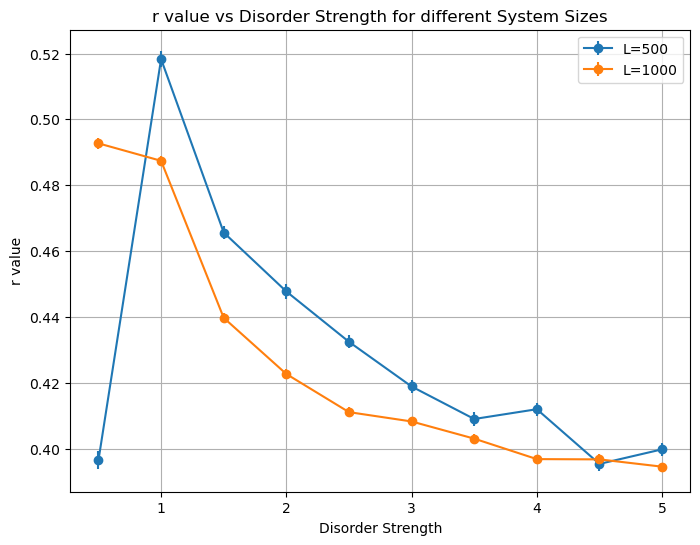

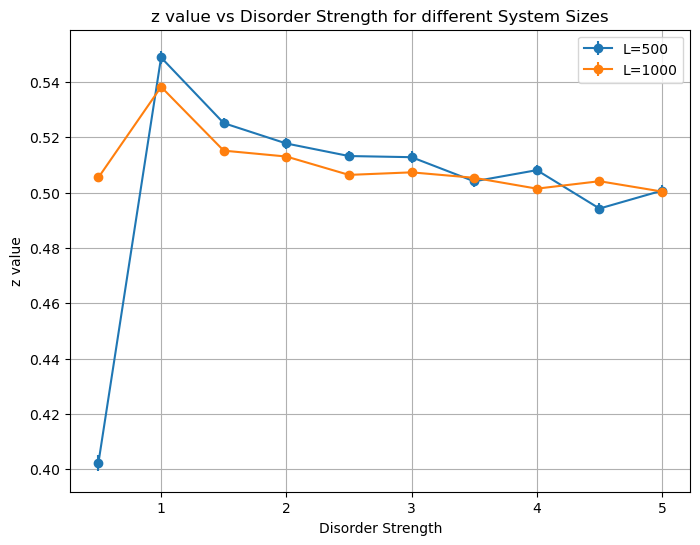

In [6]:
figr, axr = plt.subplots(figsize=(8,6))
for i,L in enumerate(L_values):
    r_vals = [r_results[i][j].mean() for j in range(len(disorder_values))]
    r_stderr = [r_results[i][j].std()/np.sqrt(num_iter) for j in range(len(disorder_values))]
    axr.errorbar(disorder_values,r_vals,yerr=r_stderr,label=f"L={L}",marker='o',capthick=2)
    #disorders = [disorder for disorder, mean, stdev in results[i]]
    #r_values = [mean for disorder, mean, stdev in results[i]]
    #stderr_values = [stdev/np.sqrt(num_iter) for disorder, mean, stdev in results[i]]
    #plt.errorbar(disorders,r_values,yerr=stderr_values,label=f"L={L}",marker='o',capthick=2)

axr.set_xlabel("Disorder Strength")
axr.set_ylabel("r value")
axr.set_title("r value vs Disorder Strength for different System Sizes")
axr.legend()
axr.grid()
figr.savefig(f"1dAnderson_r_vs_disorder_Lmax{L_values[-1]}.png",dpi=300)

figz, axz = plt.subplots(figsize=(8,6))
for i,L in enumerate(L_values):
    z_vals = [z_results[i][j].mean() for j in range(len(disorder_values))]
    z_stderr = [z_results[i][j].std()/np.sqrt(num_iter) for j in range(len(disorder_values))]
    axz.errorbar(disorder_values,z_vals,yerr=z_stderr,label=f"L={L}",marker='o',capthick=2)

axz.set_xlabel("Disorder Strength")
axz.set_ylabel("z value")
axz.set_title("z value vs Disorder Strength for different System Sizes")
axz.legend()
axz.grid()
figz.savefig(f"1dAnderson_z_vs_disorder_Lmax{L_values[-1]}.png",dpi=300)

plt.show()

In [7]:
filename = f"../data/1dAnderson_rz_results_Lmax{L_values[-1]}_iters{num_iter}OO.npz"
np.savez(filename, L_values=L_values, disorder_values=disorder_values, r_results=r_results, z_results=z_results)
print(f"Results saved to {filename}")

Results saved to ../data/1dAnderson_rz_results_Lmax1000_iters500OO.npz


In [1]:
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import math
from SLmodels import OneDimensionalAubryAndre

models = [OneDimensionalAubryAndre(L=2000,rho=30,kappa=0.1,disorder=d) for d in np.linspace(0.2,5,4)]

eigvalsH = [models[i].find_eigenvalues(models[i].H)[0] for i in range(len(models))]
#eigvecsSL = [models[i].find_eigenvalues(models[i].SL)[0] for i in range(len(models))]
#eigvecsH, eigvalsH = model.find_eigenvalues(model.H)
#eigvecs, eigvals = model.find_eigenvalues(model.SL)
# plot histogram of eigenvalues



# r, z = model.compute_statistics(model.SL)
# print(f"r: {r}, z: {z}")

# def single_iteration(args):
#     L, rho, kappa, disorder, i = args
#     model = OneDimensionalAnderson(L=L, rho=rho, kappa=kappa, disorder=disorder)
#     eigvecs, eigvals = model.find_eigenvalues(model.SL)

#     r, z = model.compute_statistics(model.SL)
#     print(f"   r value for {i+1}th iteration: {r}")
#     return r

[np.float64(0.9997461369430806), np.float64(0.7431293833640951), np.float64(0.3918768230221261), np.float64(0.38652706365233264)]
[-0.61570325 -0.61271966 -0.60973455 -0.60674795 -0.60375985 -0.60077027
 -0.59777921 -0.59478669 -0.5917927  -0.58879726 -0.58580037 -0.58280205
 -0.57980229 -0.57680111 -0.57379851 -0.57079451 -0.5677891  -0.5647823
 -0.56177412 -0.55876456 -0.55575362 -0.55274133 -0.54972768 -0.54671268
 -0.54369634 -0.54067867 -0.53765968 -0.53463936 -0.53161774 -0.52859482
 -0.5255706  -0.5225451  -0.51951832 -0.51649026 -0.51346094 -0.51043037
 -0.50739855 -0.50436549 -0.50133119 -0.49829567 -0.49525893 -0.49222098
 -0.48918183 -0.48614148 -0.48309995 -0.48005724 -0.47701335 -0.47396831
 -0.4709221  -0.46787475 -0.46482625 -0.46177662 -0.45872587 -0.455674
 -0.45262102 -0.44956693 -0.44651175 -0.44345549 -0.44039814 -0.43733972
 -0.43428024 -0.4312197  -0.42815811 -0.42509548 -0.42203182 -0.41896713
 -0.41590143 -0.41283471 -0.40976699 -0.40669828 -0.40362858 -0.400557

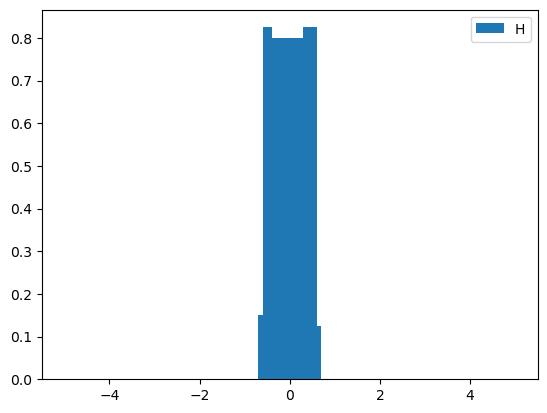

In [2]:

rvalsH = [models[i].calculate_r(eigvalsH[i]) for i in range(len(models))]
print(rvalsH)
print(eigvalsH[0])
eigvalsH = [eigvalsH[i].flatten() for i in range(len(models))]
#eigvalsSL = [eigvecsSL[i].flatten() for i in [3]]

plt.hist(eigvalsH[0], bins=100, range=(-5, 5), density=True)
#plt.hist(eigvalsSL, bins=100, range=(-5, 5), alpha=0.5, density=True)
#add legend where H is blue and SL is orange
plt.legend(['H', 'SL'])

In [1]:
def single_iteration(args):
    L, rho, kappa, disorder, X, i = args
    model = OneDimensionalAubryAndre(L=L, disorder=disorder,rho=rho, kappa=kappa, X=X)
    #eigvecs, eigvals = model.find_eigenvalues(model.SL)
    rh, zh = model.compute_statistics(model.H, 1, False)
    rsl, zsl = 0, 0 #model.compute_statistics(model.SL)
    if i % 100 == 0:
        print(f"   r value for {i+1}th iteration: {rh}")
    return rh, zh, rsl, zsl



In [7]:
L_values = [500,1000, 2000, 3000]
rho = 30
kappa = 0.1
disorder_values = np.linspace(0.5,5,10)
num_iter = 100

r_results = [[None for _ in disorder_values] for _ in L_values]
z_results = [[None for _ in disorder_values] for _ in L_values]
rsl_results = [[None for _ in disorder_values] for _ in L_values]
zsl_results = [[None for _ in disorder_values] for _ in L_values]


np.random.seed(42)

with Pool(6) as pool:
    for j, L in enumerate(L_values):
        modelforX = OneDimensionalAubryAndre(L=L, rho=rho, kappa=kappa, disorder=0)
        X = modelforX.X
        print(f"System size L: {L}")
        for k, disorder in enumerate(disorder_values):

            args_list = [(L, rho, kappa, disorder, X, i) for i in range(num_iter)]

            results = pool.map(single_iteration,args_list)


            rh_values, zh_values, rsl_values, zsl_values = zip(*results)
            r_results[j][k] = np.array(rh_values)
            z_results[j][k] = np.array(zh_values)
            rsl_results[j][k] = np.array(rsl_values)
            zsl_results[j][k] = np.array(zsl_values)
            print(f"    Disorder: {disorder}, r: {np.mean(rh_values)}, z: {np.mean(zh_values)}",flush = True)

   r value for 1th iteration: 0.8103121986817017
System size L: 500
    Disorder: 0.5, r: 0.8103121986817017, z: 0.8193640168437263
   r value for 1th iteration: 0.6602753385168308
    Disorder: 1.0, r: 0.6602753385168307, z: 0.6638996748079307
   r value for 1th iteration: 0.5640516664577437
    Disorder: 1.5, r: 0.5640516664577436, z: 0.5721695037488653
   r value for 1th iteration: 0.46707958179213876
    Disorder: 2.0, r: 0.467079581792139, z: 0.48152857507276287
   r value for 1th iteration: 0.4406898653430145
    Disorder: 2.5, r: 0.44068986534301474, z: 0.4998168712926387
   r value for 1th iteration: 0.42903737468283665
    Disorder: 3.0, r: 0.4290373746828367, z: 0.5186921413706178
   r value for 1th iteration: 0.4209619179888425
    Disorder: 3.5, r: 0.4209619179888424, z: 0.5320492396216182
   r value for 1th iteration: 0.41459836704629144
    Disorder: 4.0, r: 0.4145983670462914, z: 0.5419637026163414
   r value for 1th iteration: 0.4094567794974169
    Disorder: 4.5, r: 0.

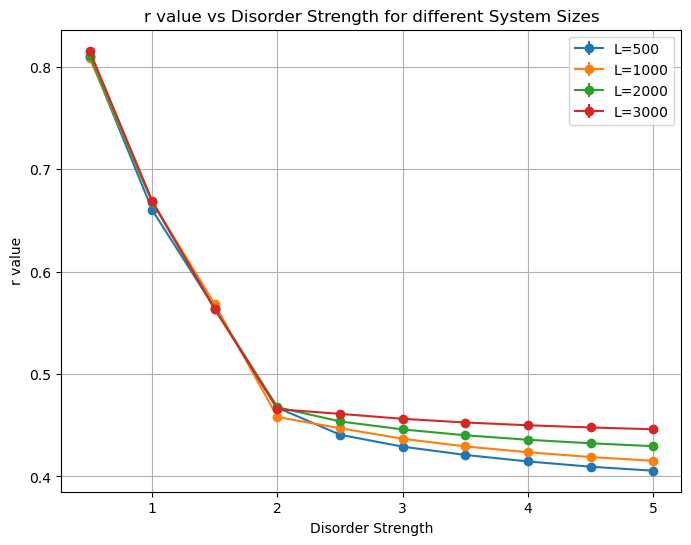

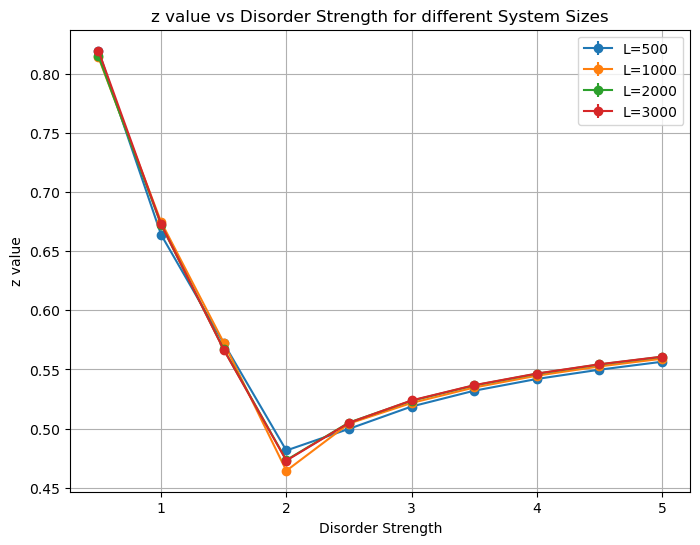

In [8]:
figr, axr = plt.subplots(figsize=(8,6))
for i,L in enumerate(L_values):
    r_vals = [r_results[i][j].mean() for j in range(len(disorder_values))]
    r_stderr = [r_results[i][j].std()/np.sqrt(num_iter) for j in range(len(disorder_values))]
    axr.errorbar(disorder_values,r_vals,yerr=r_stderr,label=f"L={L}",marker='o',capthick=2)
    #disorders = [disorder for disorder, mean, stdev in results[i]]
    #r_values = [mean for disorder, mean, stdev in results[i]]
    #stderr_values = [stdev/np.sqrt(num_iter) for disorder, mean, stdev in results[i]]
    #plt.errorbar(disorders,r_values,yerr=stderr_values,label=f"L={L}",marker='o',capthick=2)

axr.set_xlabel("Disorder Strength")
axr.set_ylabel("r value")
axr.set_title("r value vs Disorder Strength for different System Sizes")
axr.legend()
axr.grid()
figr.savefig(f"1dAnderson_r_vs_disorder_Lmax{L_values[-1]}.png",dpi=300)

figz, axz = plt.subplots(figsize=(8,6))
for i,L in enumerate(L_values):
    z_vals = [z_results[i][j].mean() for j in range(len(disorder_values))]
    z_stderr = [z_results[i][j].std()/np.sqrt(num_iter) for j in range(len(disorder_values))]
    axz.errorbar(disorder_values,z_vals,yerr=z_stderr,label=f"L={L}",marker='o',capthick=2)

axz.set_xlabel("Disorder Strength")
axz.set_ylabel("z value")
axz.set_title("z value vs Disorder Strength for different System Sizes")
axz.legend()
axz.grid()
figz.savefig(f"1dAnderson_z_vs_disorder_Lmax{L_values[-1]}.png",dpi=300)

plt.show()